In [1]:
import h5py
import numpy as np
import os
import simplejson as json
import sys
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as data

from torch.autograd import Variable

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

with open('./plots/palette.json') as json_file:
    color_palette = json.load(json_file)
    
plt.style.use('./plots/ssdjet.mplstyle')

In [3]:
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from ssd.generator import CalorimeterJetDataset
from ssd.layers.modules import MultiBoxLoss
from ssd.net import build_ssd

In [4]:
DATA_SOURCE = '/mnt/home/apol/ceph/ssd/fast'
CLASSES = ['b', 'W+H', 't']
THRESHOLD = 0.1

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = build_ssd('test', (360, 340), 4, 46., qtype='full')
net.load_weights('./models/foo.pth')
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=32)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=32)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=64)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=64)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

In [6]:
def plot_calo_image(pixels, gt=[], predictions=[], save_name=None):

    fig = plt.figure(figsize=(16, 6))

    height, width, offset = pixels.shape[1], pixels.shape[2], 15

    for index, calorimeter in enumerate(pixels):
        ax = plt.subplot(1, 2, index+1)
        ax = plt.gca()
        ax.set_xlim([-offset, width+offset])
        ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
        ax.set_ylim([-offset, height+offset])
        ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        
        # Show energy deposits
        im = ax.imshow(calorimeter,
                       norm=SymLogNorm(linthresh=0.03,
                                       vmin=0,
                                       vmax=pixels.max()),
                       interpolation='nearest')

        # Add scale
        cbar = fig.colorbar(im, extend='max')
        cbar.set_label('$E_T$ [GeV]',
                       rotation=90,
                       horizontalalignment='right',
                       y=1.0)
    
        # Add ground truth
        for box in gt:
            xmin, ymin, xmax, ymax = box[0]*width, box[1]*height, box[2]*width, box[3]*height
            jet = patches.Rectangle((xmin, ymin),
                                    xmax-xmin,
                                    ymax-ymin,
                                    linewidth=1.2,
                                    alpha=0.5,
                                    edgecolor=color_palette['red']['shade_500'],
                                    facecolor='none')
            ax.add_patch(jet)
            ax.legend(['Ground Truth'], loc='lower left', bbox_to_anchor=(0., -0.14))
            
            ax.text(xmin, ymin,
                    '{0}'.format(CLASSES[int(box[4])]),
                    weight='bold',
                    color=color_palette['grey']['shade_100'],
                    bbox={'facecolor': color_palette['red']['shade_900'],
                          'alpha': 1.0})

        # Draw the predicted boxes
        for box in predictions:
            xmin, ymin, xmax, ymax = box[2]*width, box[3]*height, box[4]*width, box[5]*height
            jet = plt.Rectangle((xmin, ymin),
                                xmax-xmin,
                                ymax-ymin,
                                linewidth=1.2,
                                alpha=0.5,
                                edgecolor=color_palette['grey']['shade_500'],
                                facecolor='none')
            ax.add_patch(jet)
            ax.legend(['Prediction'], loc='lower left', bbox_to_anchor=(0., -0.14))
            ax.text(xmin, ymin,
                    '{0}: {1:.2f}'.format(CLASSES[int(box[0])], box[1]),
                    weight='bold',
                    color=color_palette['grey']['shade_100'],
                    bbox={'facecolor': color_palette['grey']['shade_900'],
                          'alpha': 1.0})

        # Add CMS tag
        ax.text(0, 1, 'CMS',
                weight='bold',
                transform=ax.transAxes,
                color=color_palette['grey']['shade_900'],
                fontsize=14)

        # Add title
        if index:
            ax.text(0.85, 1, 'HCAL',
                    transform=ax.transAxes,
                    color=color_palette['grey']['shade_900'],
                    fontsize=14)
        else:
            ax.text(0.85, 1, 'ECAL',
                    transform=ax.transAxes,
                    color=color_palette['grey']['shade_900'],
                    fontsize=14)

        logo = OffsetImage(plt.imread('plots/hls4mllogo.jpg', format='jpg'), zoom=0.08)
        ab = AnnotationBbox(logo, [0, 0], xybox=(65, 381), frameon=False)
        ax.add_artist(ab)

    if save_name:
        fig.savefig(save_name)

    # Show plot
    plt.show();

In [7]:
val_dataset_path = '%s/RSGraviton_NARROW_2.h5' % DATA_SOURCE
h5_val = h5py.File(val_dataset_path, 'r')
val_dataset = CalorimeterJetDataset(hdf5_dataset=h5_val)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=1,
                                         shuffle=True,
                                         num_workers=1)
batch_iterator = iter(val_loader)

/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  
/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  from ipykernel import kernelapp as app
/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


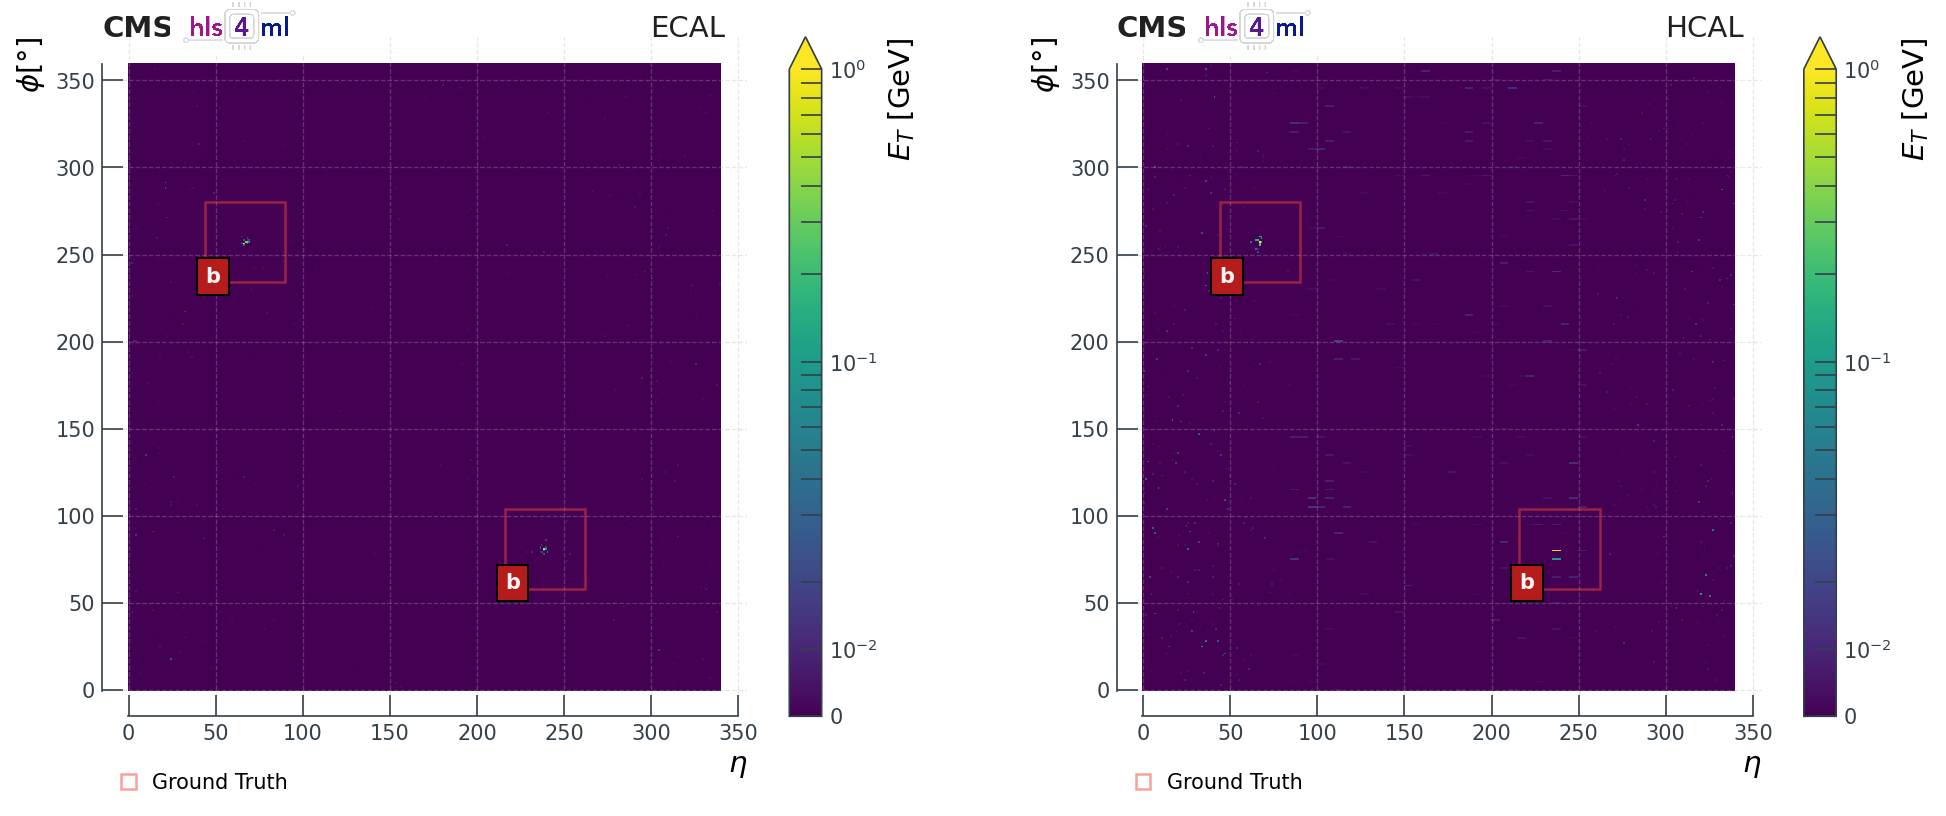

In [8]:
image, target = next(batch_iterator)
plot_calo_image(image.cpu().numpy()[0],
                target.cpu().numpy()[0],
                save_name='./plots/ssd-inference-example-gt')

/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  
/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  from ipykernel import kernelapp as app
/mnt/home/apol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


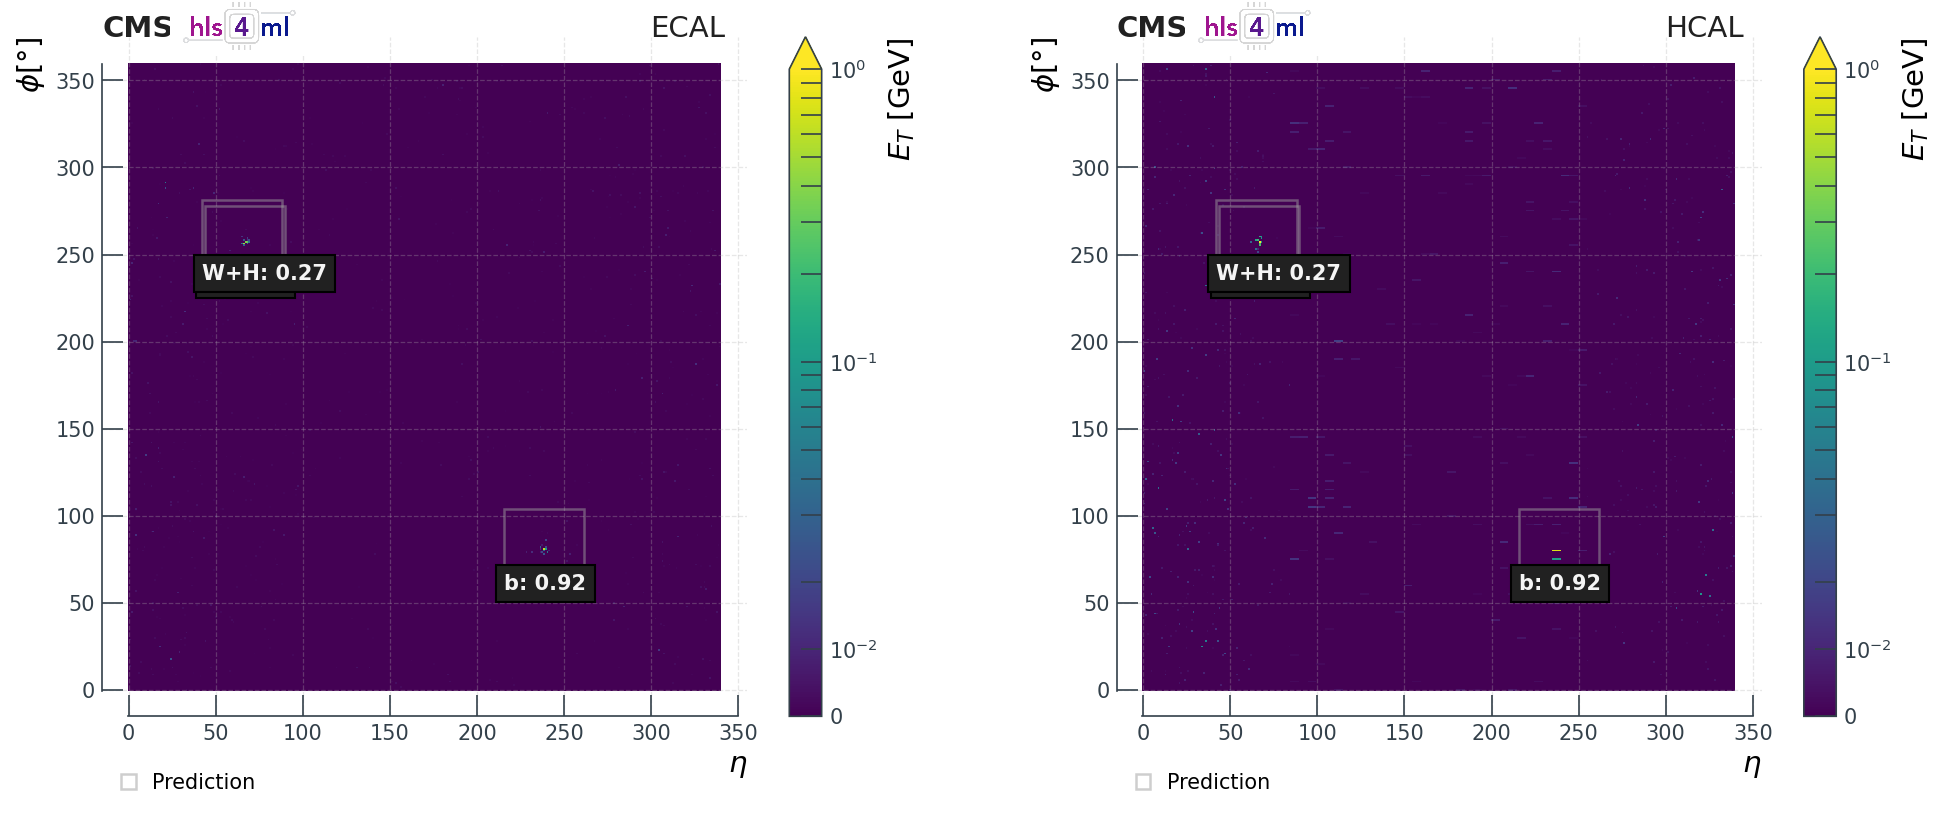

In [9]:
with torch.no_grad():
    detections = net(image).data.cpu().numpy()
    predictions = np.empty((0, 6))

    for cl, det in enumerate(detections[0]):
        columns = det.shape[1]
        mask = det[:, 0] >= THRESHOLD
        det = det.flatten()[np.repeat(mask, columns)]
        if len(det):
            det = det.reshape(-1, columns)
            cls = np.transpose(np.expand_dims(np.repeat(cl-1, det.shape[0]), 0))
            det = np.hstack((cls, det[:, :5]))
            predictions = np.vstack([predictions, det])

plot_calo_image(image.numpy()[0],
                predictions=predictions,
                save_name='./plots/ssd-inference-example-pred')

In [10]:
h5_val.close()